# 肺結節の良悪性判定(K-Fold 交差検証)

## 前準備
### 主要パッケージを読み込む
loggerの設定も行う

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from logging import basicConfig, getLogger, INFO
basicConfig(level=INFO, format='%(asctime)s %(levelname)s :%(message)s')
logger = getLogger(__name__)

### データディレクトリの指定

In [2]:
DATA_ROOT = pathlib.Path('Data/Images/LIDC_PN')
CLASS_LABELS = ('benign', 'malignant')
IMAGE_EXT = '.png'

### 画像ファイルを基にpd.DataFrameを作成する
クラスごとにDataFrameを作成した後に結合する。

In [3]:
import tut_utils
df_dataset = tut_utils.create_dataset_df(DATA_ROOT, CLASS_LABELS, IMAGE_EXT)
assert set(CLASS_LABELS) == set(df_dataset['class_label'].unique(
)), 'Discrepancy between CLASS_LABELS and df_dataset'
display(df_dataset)

filepath class_label  class
0       Data\Images\LIDC_PN\benign\001.png      benign      0
1       Data\Images\LIDC_PN\benign\002.png      benign      0
2       Data\Images\LIDC_PN\benign\007.png      benign      0
3       Data\Images\LIDC_PN\benign\011.png      benign      0
4       Data\Images\LIDC_PN\benign\012.png      benign      0
..                                     ...         ...    ...
604  Data\Images\LIDC_PN\malignant\177.png   malignant      1
605  Data\Images\LIDC_PN\malignant\178.png   malignant      1
606  Data\Images\LIDC_PN\malignant\179.png   malignant      1
607  Data\Images\LIDC_PN\malignant\180.png   malignant      1
608  Data\Images\LIDC_PN\malignant\181.png   malignant      1

[609 rows x 3 columns]

### データ読み込み用の関数を作成

In [4]:
import tensorflow as tf
IMG_SHAPE = (64, 64, 1)


def load_img(filepath):
    return np.atleast_3d(
        tf.keras.preprocessing.image.load_img(
            filepath,
            color_mode='grayscale' if IMG_SHAPE[2] == 1 else 'rgb',
            target_size=IMG_SHAPE))


def load_dataset(df_train, df_test):
    train_data = np.stack(
        [load_img(filepath) for filepath in df_train['filepath']])
    train_labels = df_train['class']
    test_data = np.stack(
        [load_img(filepath) for filepath in df_test['filepath']])
    test_labels = df_test['class']

    train_data = train_data / 255
    test_data = test_data / 255

    return train_data, train_labels, test_data, test_labels

## Data augmentation
いくつかの画像に対して実際にaugmentationを適用し表示する

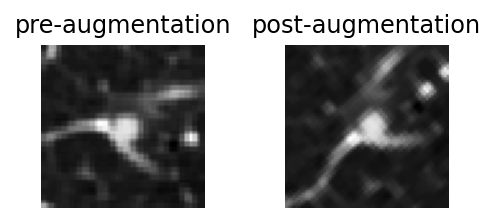

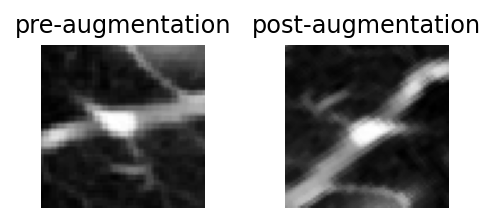

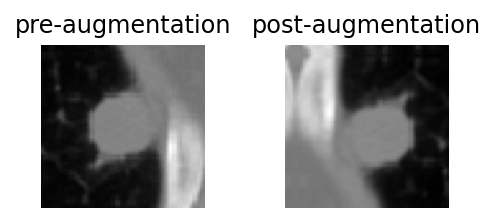

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def create_generator():
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=.05,
        fill_mode='reflect',
    )
    return datagen


N_TEST = 3


def test_generator(df_dataset):
    df_train = df_dataset.iloc[:N_TEST]
    df_tmp = df_dataset.iloc[N_TEST:(N_TEST + 1)]
    train_data, train_labels, test_data, test_labels = load_dataset(
        df_train, df_tmp)
    datagen = create_generator()
    flow = datagen.flow(train_data, train_labels, batch_size=1, shuffle=False)
    for i in range(N_TEST):
        plt.figure(figsize=(4, 1.5))
        plt.subplot(1, 2, 1)
        plt.imshow(train_data[i].squeeze(), cmap='gray')
        plt.title('pre-augmentation')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        t = flow[i]
        plt.imshow(t[0].squeeze(), cmap='gray')
        plt.title('post-augmentation')
        plt.axis('off')
        plt.show()


test_generator(df_dataset)

## ネットワーク作成関数を作成
関数にするのは交差検証のfold毎に新しいmodelを作成する必要があるため。

In [6]:
import tensorflow as tf
from tensorflow.keras import layers


def build_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(4, 3, activation='relu', input_shape=IMG_SHAPE))
    model.add(layers.Conv2D(4, 3, activation='relu'))
    model.add(layers.BatchNormalization(momentum=0.90))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Conv2D(8, 3, activation='relu'))
    model.add(layers.Conv2D(8, 3, activation='relu'))
    model.add(layers.BatchNormalization(momentum=0.90))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Conv2D(16, 3, activation='relu'))
    model.add(layers.Conv2D(16, 3, activation='relu'))
    model.add(layers.BatchNormalization(momentum=0.90))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Dropout(.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

## K-Fold 交差検証
分割にはsklearnの[StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)を使う。
<div class="alert alert-block alert-warning">
<b>注意:</b> 今回、epoch数は決め打ちしてありますが、本来はvalidationデータを用いて学習を終了させる必要があります。
</div>

2020-06-16 10:42:56,098 INFO :1th iteration of 3-fold CV
1/64 epoch:   0%|          | 0/400 [00:00<?, ?batch/s]2020-06-16 10:42:57,659 WARNING :sample_weight modes were coerced from
  ...
    to  
  ['...']
64/64 epoch [20s/20s (0.32s/epoch) last_epoch=(loss=0.241,accuracy=0.91)]: : 408batch [00:00, 1450.79batch/s, loss=0.191, accuracy=0.882]


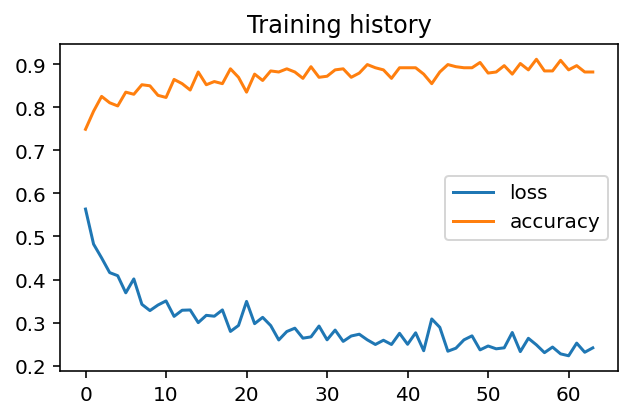

2020-06-16 10:43:18,701 INFO :2th iteration of 3-fold CV


[0.38440013636509185, 0.87684727]


1/64 epoch:   0%|          | 0/400 [00:00<?, ?batch/s]2020-06-16 10:43:18,982 WARNING :sample_weight modes were coerced from
  ...
    to  
  ['...']
35/64 epoch [10s/19s (0.29s/epoch) last_epoch=(loss=0.3,accuracy=0.854)]:  32%|███▏      | 128/400 [00:00<00:00, 1326.50batch/s, loss=0.344, accuracy=0.778]

In [7]:
from sklearn.model_selection import StratifiedKFold
K_FOLD = 3
kfold = StratifiedKFold(n_splits=K_FOLD, shuffle=True)

BATCH_SIZE = 8
EPOCHS = 64


def predict_binary(model, data, index):
    logits = model.predict(data).squeeze()
    predictions = tf.nn.sigmoid(logits).numpy()
    df_result = pd.DataFrame(
        {
            'pred_logits': logits,
            'pred_proba': predictions,
            'pred_class': predictions > .5
        },
        index=index)
    return df_result


results = []
for i_iter, (train_index, test_index) in enumerate(
        kfold.split(df_dataset['filepath'], df_dataset['class'])):
    logger.info('{i}th iteration of {k}-fold CV'.format(i=i_iter + 1,
                                                        k=K_FOLD))
    df_train = df_dataset.iloc[train_index]
    df_test = df_dataset.iloc[test_index]
    train_data, train_labels, test_data, test_labels = load_dataset(
        df_train, df_test)
    model = build_model()
    datagen = create_generator()
    with tut_utils.ProgressBarCallback(EPOCHS, len(train_index) // BATCH_SIZE,
                                       BATCH_SIZE) as pbar:
        result = model.fit(datagen.flow(train_data,
                                        train_labels,
                                        shuffle=True,
                                        batch_size=BATCH_SIZE),
                           epochs=EPOCHS,
                           verbose=0,
                           callbacks=[pbar])
    pd.DataFrame(result.history).plot(title='Training history', figsize=(5, 3))
    plt.show()
    print(model.evaluate(test_data, test_labels, verbose=0))
    results.append(predict_binary(model, test_data, test_index))

In [8]:
df_result = pd.concat(results, axis=0)
df_result = df_dataset.join(df_result)
display(df_result)

filepath class_label  class  pred_logits  \
0       Data\Images\LIDC_PN\benign\001.png      benign      0    -1.375776   
1       Data\Images\LIDC_PN\benign\002.png      benign      0    -2.285815   
2       Data\Images\LIDC_PN\benign\007.png      benign      0     2.464804   
3       Data\Images\LIDC_PN\benign\011.png      benign      0    -2.805609   
4       Data\Images\LIDC_PN\benign\012.png      benign      0     1.196478   
..                                     ...         ...    ...          ...   
604  Data\Images\LIDC_PN\malignant\177.png   malignant      1     4.255023   
605  Data\Images\LIDC_PN\malignant\178.png   malignant      1    14.381430   
606  Data\Images\LIDC_PN\malignant\179.png   malignant      1     0.834561   
607  Data\Images\LIDC_PN\malignant\180.png   malignant      1    -1.809841   
608  Data\Images\LIDC_PN\malignant\181.png   malignant      1     7.591059   

     pred_proba  pred_class  
0      0.201688       False  
1      0.092305       False  
2      0.921637        True  
3      0.057022       False  
4      0.767898        True  
..          ...         ...  
604    0.986006        True  
605    0.999999        True  
606    0.697318        True  
607    0.140657       False  
608    0.999495        True  

[609 rows x 6 columns]

## 評価
### 混同行列

In [9]:
from sklearn import metrics


def confusion_matrix(df_result):
    class_labels = df_result['class_label'].unique()
    cm = metrics.confusion_matrix(df_result['class'], df_result['pred_class'])
    df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    df_cm.index.name, df_cm.columns.name = 'Truth', 'Prediction'
    return df_cm


df_cm = confusion_matrix(df_result)
print('Accuracy = {n} / {d} = {a:.03g}%'.format(n=df_cm.values.trace(),
                                                d=df_cm.values.sum(),
                                                a=100 * df_cm.values.trace() / df_cm.values.sum()))

display(df_cm)

Accuracy = 532 / 609 = 87.4%


Prediction  benign  malignant
Truth                        
benign         392         40
malignant       37        140

### ROCカーブ

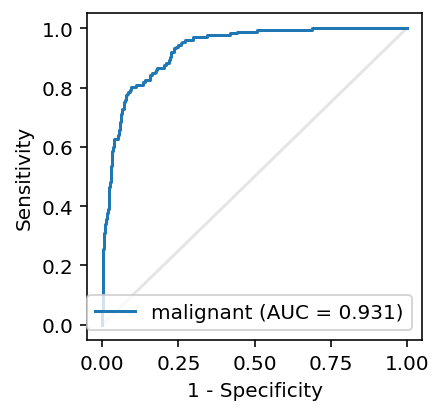

In [10]:
tut_utils.plot_roc_curves(df_result)
plt.show()

### カットオフ値
[Youden's J statistic](https://en.wikipedia.org/wiki/Youden's_J_statistic)をもとにカットオフ値を決める。

In [11]:
fpr, tpr, thresholds = metrics.roc_curve(df_result['class'],
                                                 df_result['pred_proba'])
cutoff_idx = np.argmax(np.array(tpr)-np.array(fpr))
cutoff_fpr, cutoff_tpr, cufoff = fpr[cutoff_idx], tpr[cutoff_idx], thresholds[cutoff_idx]
print('cut-off={:.3g}, sensitivity={:.3g}, specificity={:.3g}'.format(cufoff, cutoff_tpr, 1-cutoff_fpr))

cut-off=0.497, sensitivity=0.802, specificity=0.905


### Probability Calibration curves

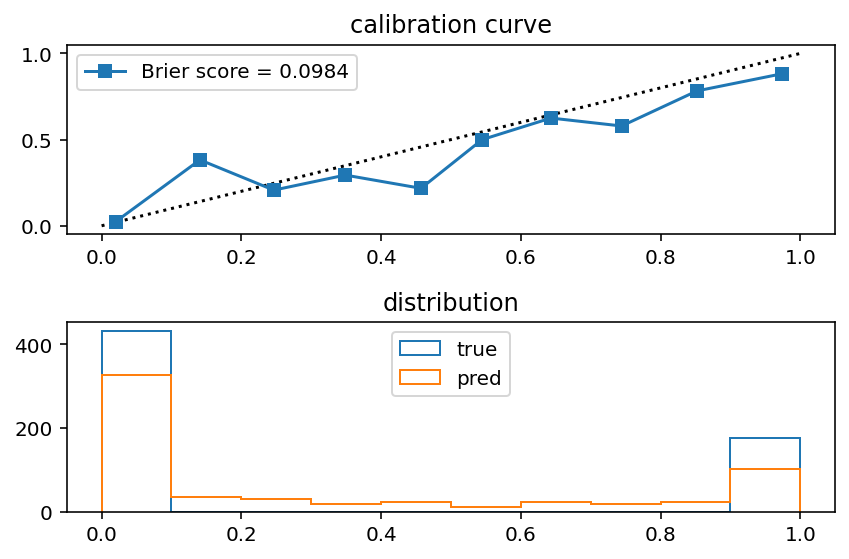

In [12]:
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(df_result['class'],
                                                                df_result['pred_proba'],
                                                                n_bins=10)
brier_score = metrics.brier_score_loss(df_result['class'], df_result['pred_proba'])
plt.subplot(2,1,1)
plt.plot([0, 1], [0, 1], 'k:')
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Brier score = {:.3g}'.format(brier_score))
plt.legend()
plt.title('calibration curve')
plt.subplot(2,1,2)
plt.hist(df_result['class'],histtype="step",label='true')
plt.hist(df_result['pred_proba'],histtype="step",label='pred')
plt.title('distribution')
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()

### Decision Curve Analysis
準備中